In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
import timeit

## Defining the generic metrics class

In [3]:
class GeneralModelClass:
    # Where k∗ is the numbers of parameters you're estimating INCLUDING an intercept. 
    #(The residual vector will exist in an n−k∗ dimensional linear space.)
   
    # If you include an intercept term in a regression and k refers to the number of regressors
    # not including the intercept then k∗=k+1.
         
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.predict(self.data)) ** 2
        #squared_errors = 
        self.sq_error_ = np.sum(squared_errors)
        return self.sq_error_
        
    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        self.sst_ = np.sum(squared_errors)
        return self.sst_
    
    def r_squared(self):
        '''returns calculated value of r^2'''
        self.r_sq_ = 1 - self.sse()/self.sst()
        return self.r_sq_
    
    def adj_r_squared(self):
        '''returns calculated value of adjusted r^2'''
        self.adj_r_sq_ = 1 - (self.sse()/self._dfe) / (self.sst()/self._dft)
        return self.adj_r_sq_
    
    def rmse(self):
        '''returns calculated value of mse'''
        # using predict, data and target, find the RMSE error
        self.rmse_ = np.mean( (self.predict(self.data) - self.target) ** 2 )
        return self.rmse_
    
    def pretty_print_stats(self):
        '''returns report of statistics for a given model object'''
        items = ( ('rmse:', self.rmse()), ('r^2:', self.r_squared()), 
                  ('adj_r^2:', self.adj_r_squared()))
        for item in items:
            print('{0:8} {1:.4f}'.format(item[0], item[1]))


## Defining the Linear Regression Class

In [4]:
# only makes sense for Linear Regression https://stats.stackexchange.com/questions/23128/solving-for-regression-parameters-in-closed-form-vs-gradient-descent
class LinearRegression_(GeneralModelClass):
    
       
    
    def __init__(self, fit_intercept=True):
        
        self.coef_ = None
        self.intercept_ = None
        self._fit_intercept = fit_intercept
          
        
    def fit(self, X, y):
        """
        Fit model coefficients.

        Arguments:
        X: 1D or 2D numpy array 
        y: 1D numpy array
        """
         #degrees of freedom population dep. variable variance -- this is total amount of degrees
        self._dft = X.shape[0] - 1   
        # degrees of freedom for the residuals
        self._dfe = X.shape[0] - X.shape[1] - 1  # the more independent variables, the less adj_R-sq
        
        # training data & ground truth data
        self.data = X
        self.target = y
                
        # check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)
            
        # add bias if fit_intercept - it is an inbuilt method in stats model which adds constant to model, in other terms it adds constant 1 to the input 
        if self._fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        
        # closed form solution
        xTx = np.dot(X.T, X)
        inverse_xTx = np.linalg.inv(xTx) # find the inverse of the cov matrix, i.e. the precision matrix
        xTy = np.dot(X.T, y)
        coef = np.dot(inverse_xTx, xTy) # this is nothing but slope or beta or m
        
        # set attributes
        if self._fit_intercept:
            self.intercept_ = coef[0]
            self.coef_ = coef[1:]
        else:
            self.intercept_ = 0
            self.coef_ = coef
            
    def predict(self, X):
        """Output model prediction.

        Arguments:
        X: 1D or 2D numpy array 
        """
        # check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)  # force 1D array into a column vector
        return self.intercept_ + np.dot(X, self.coef_) #using intercept, coefficients and X and linear regression formula, find the predictions
    
    def __str__(self):
        return "Results: b: {}, m: {}, Final Total error: {}".format(round(self.b, 2), round(self.m, 2), round(self.compute_error(), 2))

## The Problem : Housing Price Prediction

### Loading the Dataset

In [5]:
from sklearn.datasets import load_boston
import pandas as pd
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Understanding the Data using Metadata

In [6]:
print(boston_dataset.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [7]:
# find the sum of null values for each variable
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Visualizing  The Dependent Variable

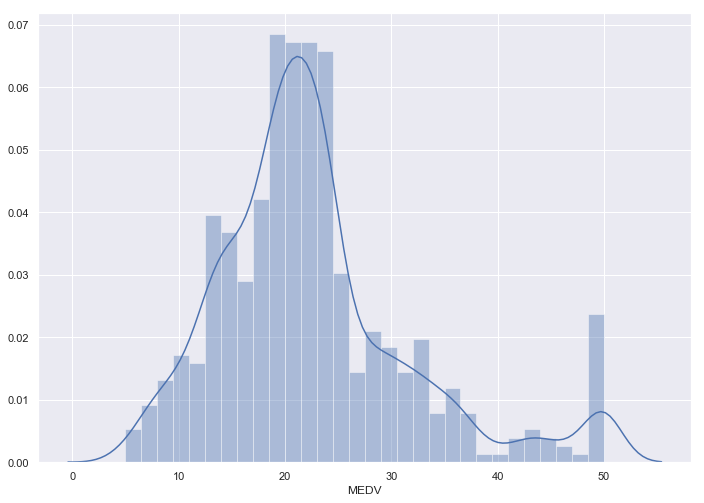

In [9]:
import seaborn as sns
% matplotlib inline
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
# visualize the distribution of the dependent variable (KDE + 30-bin histogram)
sns.distplot(boston['MEDV'],hist=True, bins=30);

### Visualizing Pairwise Relationships

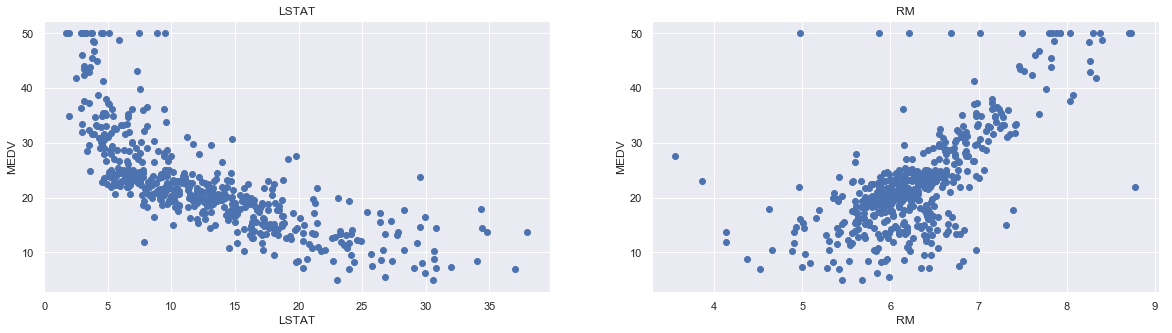

In [10]:
plt.figure(figsize=(20, 5))

# choose your own custom features here and make subplots to visualize pairwise relationships
#sns.pairplot(data = boston,hue = 'LSTAT', kind = "scatter")
#diag_kind = "kde"
# alternatively, you may use the pairplot
features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Iris Features')

for ax, feature, name in zip(axes.flatten(), boston.boston.T, boston.feature_names):
    ax.hist(feature, bins=len(np.unique(boston.boston.T[0]))//2)
    ax.set(title=name[:-4].upper(), xlabel='cm')


In [11]:
x_vars = boston.columns.difference(['MEDV'])
y_vars = ['MEDV']
print(boston.columns)
print(x_vars)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')
Index(['AGE', 'B', 'CHAS', 'CRIM', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO',
       'RAD', 'RM', 'TAX', 'ZN'],
      dtype='object')


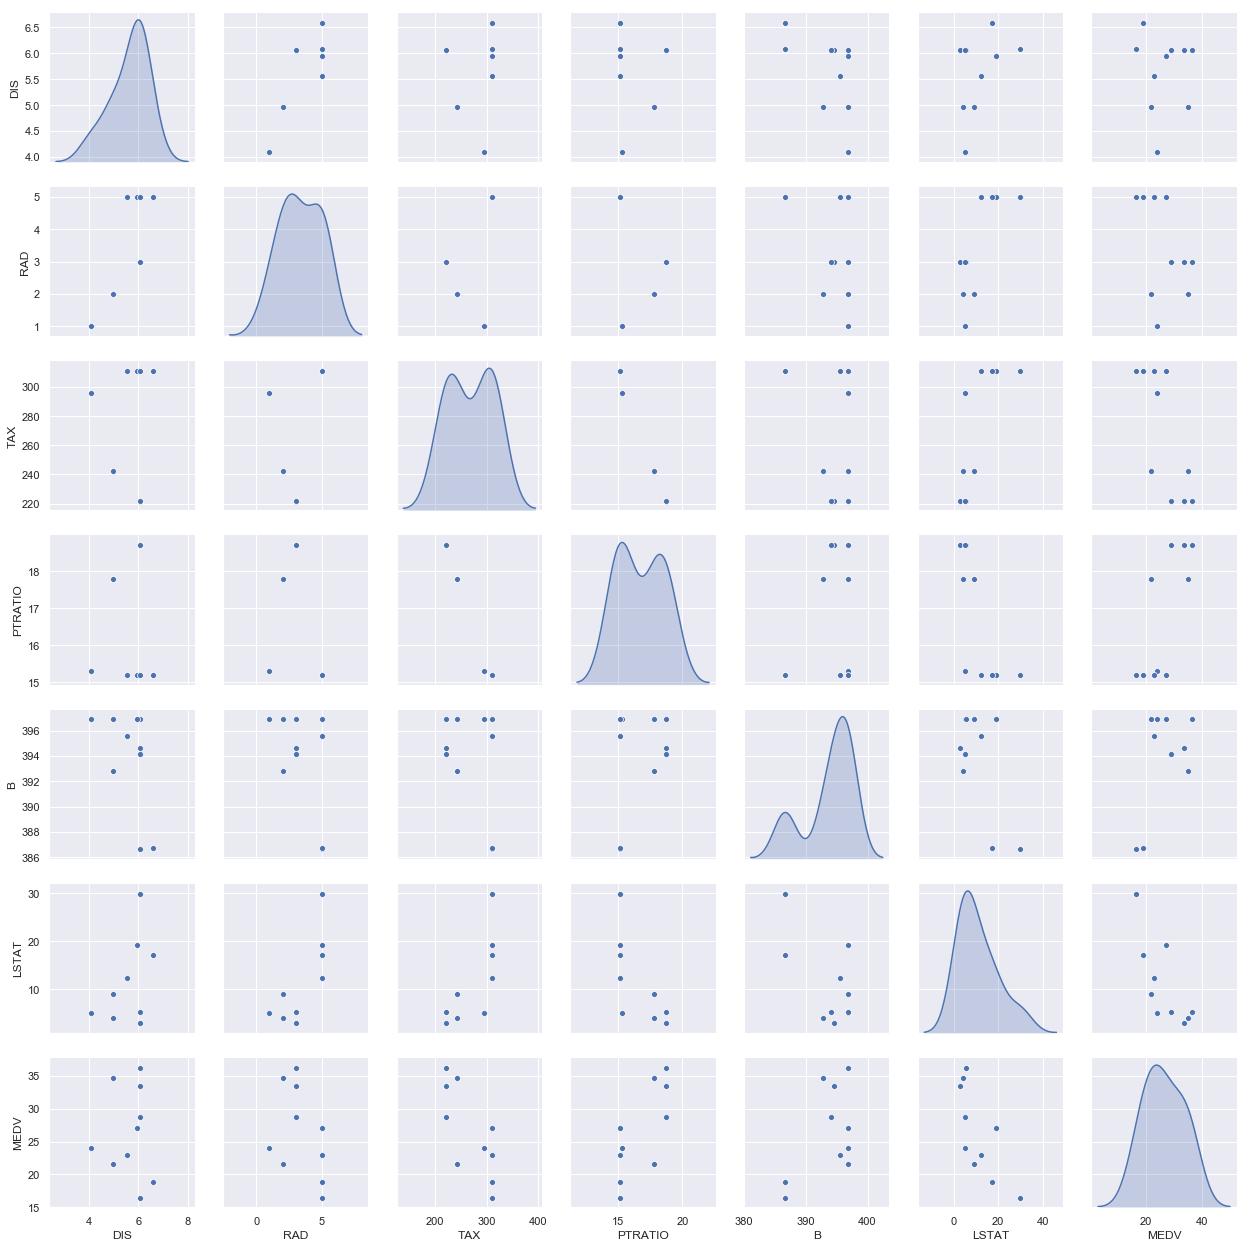

In [12]:
import seaborn as sns
#sns.pairplot(data=boston.iloc[0:10,:],x_vars=x_vars,y_vars=y_vars, hue = "RAD")
sns.pairplot(data=boston.iloc[0:10,:],vars = boston.columns[-7:],diag_kind="kde")
#sns.pairplot(data=boston.iloc[0:10,:]) runs very slowly

## Modeling

### Selecting Features Based on Correlation

In [13]:
print(boston.corr())

             CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
CRIM     1.000000 -0.199458  0.404471 -0.055295  0.417521 -0.219940  0.350784   
ZN      -0.199458  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
INDUS    0.404471 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
CHAS    -0.055295 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
NOX      0.417521 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
RM      -0.219940  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
AGE      0.350784 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
DIS     -0.377904  0.664408 -0.708027 -0.099176 -0.769230  0.205246 -0.747881   
RAD      0.622029 -0.311948  0.595129 -0.007368  0.611441 -0.209847  0.456022   
TAX      0.579564 -0.314563  0.720760 -0.035587  0.668023 -0.292048  0.506456   
PTRATIO  0.288250 -0.391679  0.383248 -0.121515  0.188933 -0.355501  0.261515   
B       -0.377365  0.175520 

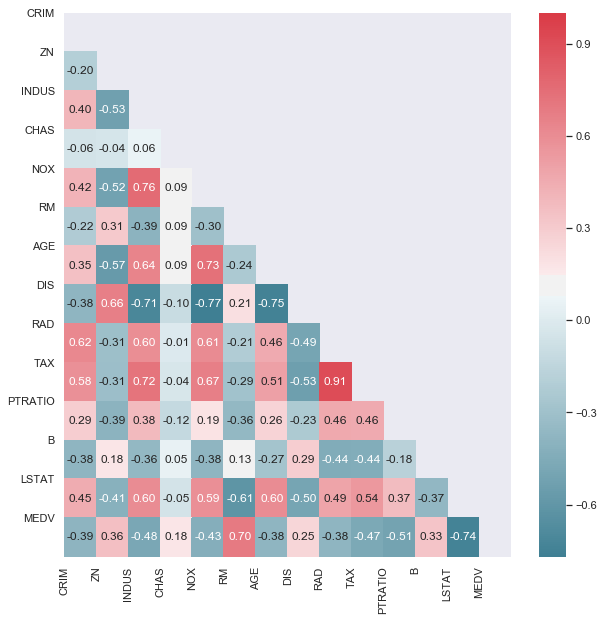

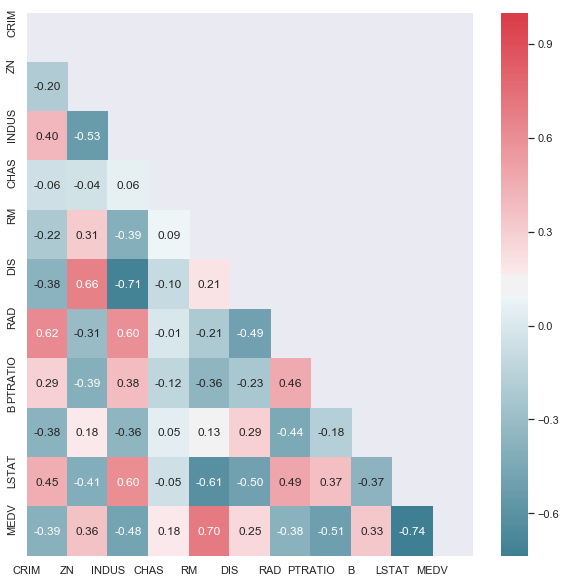

In [14]:
def doCorrelationReduction(corr_matrix = boston.corr(), original_data = boston, corr_thr=0.7):
    """Method to  select only the data with features that have low correlations between themselves"""
    import numpy as np
    corr_matrix_abs = corr_matrix.abs()
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))  # # Select upper triangle of correlation matrix
    # # Find index of feature columns with correlation greater than threshold
    #print(upper)
    to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

    # [inside the list, using upper.columns, select any column (name) that has higher correlation than corr_thr value]
    low_cor_data = boston.drop(to_drop, axis = 1)
    #low_cor_data = boston.columns.difference(to_drop)
    # using the difference operator on the original data dataframe columns, subtract the to_drop columns

    return low_cor_data

def heatMap(df, mirror=False):

   # Create Correlation df
   corr = df.corr()
   # Plot figsize
   fig, ax = plt.subplots(figsize=(10, 10))
   # Generate Color Map
   colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
   if mirror == True:
      #Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
      #Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      #Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
      #show plot

   else:
      # Drop self-correlations
      dropSelf = np.zeros_like(corr)
      dropSelf[np.triu_indices_from(dropSelf)] = True
      # Generate Color Map
      colormap = sns.diverging_palette(220, 10, as_cmap=True)
      # Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
      # Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      # Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
   # show plot
   plt.show()
    
heatMap(df=boston)
boston_corr_reduced = doCorrelationReduction()
heatMap(df=boston_corr_reduced)

## Ignore the below code

### Notice Any Dimensionality Reduction?

In [15]:


def doCorrelationReduction(corr_matrix = boston.corr(), original_data = boston, corr_thr=0.7):
    """Method to  select only the data with features that have low correlations between themselves"""
    import numpy as np
    corr_matrix_abs = corr_matrix.abs()
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(np.bool))  # # Select upper triangle of correlation matrix
    # # Find index of feature columns with correlation greater than threshold
    #print(upper)
    to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
    #print(to_drop)

    # [inside the list, using upper.columns, select any column (name) that has higher correlation than corr_thr value]
    #low_cor_data = boston.columns.difference(to_drop)
    low_cor_data = boston.drop(to_drop, axis = 1)
    # using the difference operator on the original data dataframe columns, subtract the to_drop columns

    return low_cor_data

doCorrelationReduction()


,CRIM,ZN,INDUS,CHAS,RM,DIS,RAD,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,6.575,4.0900,1.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,6.421,4.9671,2.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,7.185,4.9671,2.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,6.998,6.0622,3.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,7.147,6.0622,3.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,6.430,6.0622,3.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,6.012,5.5605,5.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,6.172,5.9505,5.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,5.631,6.0821,5.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,6.004,6.5921,5.0,15.2,386.71,17.10,18.9


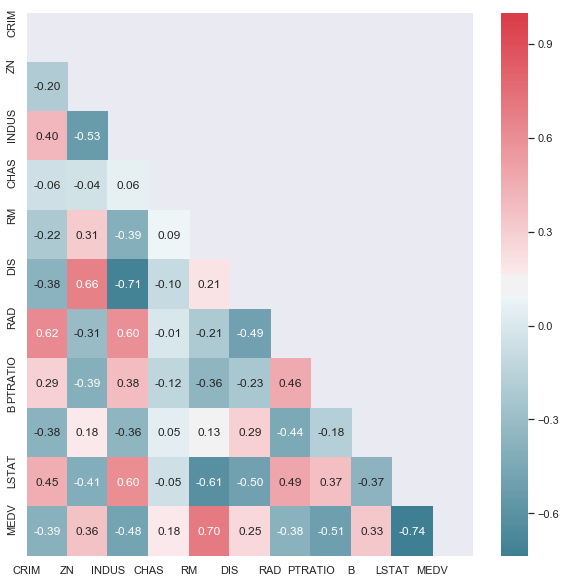

In [16]:
heatMap(boston_corr_reduced)

### Splitting Data for Measuring Generalization Error

In [17]:
import pandas as pd
X = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns = ['LSTAT','RM'])
Y = boston['MEDV']
#print(X)
#print(Y)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
#print(X_train)
#print(X_test)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 2)
(102, 2)
(404,)
(102,)


### Linear Regression Using Your Own OOP Implementation

In [18]:

#importlib.reload(mymodule) # https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
#%load_ext autoreload

general_model = GeneralModelClass()
linreg_model = LinearRegression_(general_model)
linreg_model.__dict__


linreg_model.fit(X=X_train,y=Y_train)


In [19]:
linreg_model.pretty_print_stats()

rmse:    31.7772
r^2:     0.6301
adj_r^2: 0.6282


In [20]:
import inspect
lines = inspect.getsource(linreg_model.pretty_print_stats)
print(lines)

    def pretty_print_stats(self):
        '''returns report of statistics for a given model object'''
        items = ( ('rmse:', self.rmse()), ('r^2:', self.r_squared()), 
                  ('adj_r^2:', self.adj_r_squared()))
        for item in items:
            print('{0:8} {1:.4f}'.format(item[0], item[1]))





**make sure if you add features that you transform both train and test when you transform your data**


### Linear Regression Using Statsmodels

You can implement linear regression in Python relatively easily by using the package statsmodels as well. Typically, this is desirable when there is a need for more detailed results.

In [26]:
import statsmodels.api as sm
X_constant_added = sm.add_constant(X)
model = sm.OLS(y,X_constant_added)
results = model.fit()
print(results.summary())
print('coefficient of determination:', results.rsquared)
print('adjusted coefficient of determination:', results.rsquared_adj)
print('regression coefficients:', results.params)
predictions = model.predict(X)
print(predictions)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     444.3
Date:                Fri, 09 Aug 2019   Prob (F-statistic):          7.01e-112
Time:                        10:33:59   Log-Likelihood:                -1582.8
No. Observations:                 506   AIC:                             3172.
Df Residuals:                     503   BIC:                             3184.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3583      3.173     -0.428      0.6

ValueError: shapes (506,3) and (506,2) not aligned: 3 (dim 1) != 506 (dim 0)

## Task : Multiple Regression Comparison with Different Libraries


In this task, your task is to predict the Median value of owner-occupied homes in $1000's in Boston, using multiple different features.

**Before you start : Split the Boston housing dataset into training and test sets using Scikit-learn train-test split function.**

Starting Question : 
**Compare the Implementation of the matrix transformations in the `fit`-method of the Linear Regression implementation to the tasks in the last assignments. What do you notice? What is the closed form solution called in other words? We talked about this on Monday.**

- 0.0 Are the features linearly independent of each other? Show this programmatically.
- 0.1 Are the assumptions for linear regression fulfilled?

[assumptions](https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0)


In the next steps, we will look at some concrete models. **Remember to measure both the training and prediction times of your runs.**

0.0 Referring to the maximum likelihood notebook, implement a method to compute the negative log-likelihood.

- 1.0 Define **optimize (train)** a multiple linear regression model in Scikit-Learn with all features
- 1.1 Define **optimize (train)** a multiple linear regression model in Scikit-Learn with low correlated features

[Scikit Lin Reg](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

**What fitting methods are available here?**


- 3.0 Define and **optimize (train)** a multiple linear regression model in statsmodels with all features
- 3.1  Define and **optimize (train)** a multiple linear regression model in statsmodels with low correlated features

[Statsmodels Lin Reg](https://www.statsmodels.org/stable/regression.html)

"This module allows estimation by ordinary least squares (OLS), weighted least squares (WLS), generalized least squares (GLS), and feasible generalized least squares with autocorrelated AR(p) errors."

- Which library (statsmodels or Scikit-learn) allows for more flexible fitting procedure?


- 5. Remember that the training error is not a good metric for evaluation how well a model generalizes. That's why you should now compare the results by MSE achieved on the test set. 


- Which model generalizes the best? Plot the MSE VS neg-log-likelihood for each of the models. Why does the graph look like it does?
- Did you see any significant improvement in generalization by eliminating features that are highly correlated to others?
- Was there any considerable speed differences between the runtimes of the model? Did you use GPU or not?



### BONUS POINT QUESTIONS (+1.5 %):

----------------------------------------------------------
- 2.0 Define and **optimize (train)** a multiple **polynomial** regression model in Scikit-Learn with all features
- 2.1 Define and **optimize (train)** a multiple **polynomial** regression model in Scikit-Learn with low correlated features

AND

- Use Bayesian Feature Selection (refer to the appropriate method in SkLearn or Lasso to Select the best performing features).

---------------------------------------------------------------------
AND

- 4.0 Define and **optimize (train)** a multiple linear regression model in Pytorch with all features
- 4.1 Define and **optimize (train)** a multiple linear regression model in Pytorch with low correlated features


**What needs to be included** :

Answers to the previously mentioned questions, but now comparing all the trained models between each other:

- Which model generalizes the best?  Plot the MSE VS neg-log-likelihood for each of the models. Why does the graph look like it does?
- Did you see any significant improvement in generalization by eliminating features that are highly correlated to others?
- Was there any considerable speed differences between the runtimes of the model? Did you use GPU or not?

In [45]:
## predicted response
print('predicted response:', results.fittedvalues, sep='\n')
print('predicted response:', results.predict(X_constant_added), sep='\n')


predicted response:
0      28.941014
1      25.484206
2      32.659075
3      32.406520
4      31.630407
5      28.054527
6      21.287078
7      17.785597
8       8.104693
9      18.246507
10     17.994962
11     20.732213
12     18.553484
13     23.644741
14     23.108958
15     22.923945
16     24.652576
17     19.736110
18     18.929722
19     20.573776
20     13.517324
21     20.148322
22     17.908967
23     15.487646
24     18.352810
25     16.562109
26     18.744403
27     18.349958
28     23.510188
29     24.948889
         ...    
476    19.677079
477     9.663337
478    18.571270
479    21.955844
480    23.544465
481    28.059693
482    30.113093
483    21.304522
484    19.984167
485    24.003878
486    20.168733
487    21.371447
488    14.827709
489    10.827580
490     5.524287
491    17.516429
492    20.548360
493    20.002959
494    20.103791
495    16.223668
496    12.523179
497    19.103676
498    21.007986
499    17.314991
500    20.143019
501    26.020059
502    23.9

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


In [28]:
from pandas import DataFrame
from sklearn import linear_model

In [32]:
X1 = boston[boston.columns.difference(['MEDV'])]
Y1 = boston['MEDV']

In [33]:
#X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = 0.2, random_state=5)

In [34]:
## Median of the age
print(X1['AGE'].median())

77.5


In [35]:
%%timeit

linreg_model_sklearn = LinearRegression().fit(X, Y)


In [36]:
print('Intercept: \n', linreg_model_sklearn.intercept_)
print('Coefficients: \n', linreg_model_sklearn.coef_)

Intercept: 
 -1.3582728118745173
Coefficients: 
 [-0.64235833  5.09478798]


In [91]:
%%timeit
## Comparison of Predictions
y_pred_own = linreg_model.predict(X_test)
#print(y_pred_own)
y_pred_sklearn = linreg_model.predict(X_test)
#print(y_pred_sklearn)


107 µs ± 6.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
print('score of Linear regression is {}'.format(linreg_model_sklearn.score(X_test,Y_test)))
#r_squared
print('score of Linear regression using OOPS is {}'.format(linreg_model.r_squared()))

score of Linear regression is 0.6836598221754846
score of Linear regression using OOPS is 0.6300745149331701


### Linear Independence / Dependence
[stats stackexchange reference](https://stats.stackexchange.com/questions/92522/linearly-dependent-features)


In [38]:
from numpy.linalg import matrix_rank
if matrix_rank(boston.values) == len(boston.columns):
    print("You have a full-rank data matrix, no linearly dependent features!")
else :
    print("Some features are linearly dependent!")


You have a full-rank data matrix, no linearly dependent features!


Linear regression is used as a predictive model that assumes a linear relationship between the dependent variable (which is the variable we are trying to predict/estimate) and the independent variable/s (input variable/s used in the prediction).

In [39]:
from pandas import DataFrame
from sklearn import linear_model

In [40]:
X1 = boston[boston.columns.difference(['MEDV'])]
Y1 = boston['MEDV']

In [41]:
### MultiLinear Regression
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = 0.2, random_state=5)
linreg_model_sklearn = LinearRegression().fit(X1, Y1)
print('Intercept: \n', linreg_model_sklearn.intercept_)
print('Coefficients: \n', linreg_model_sklearn.coef_)
#regcoef = np.array(linreg_model_sklearn.coef_)
#print(regcoef)


Intercept: 
 36.4911032803614
Coefficients: 
 [ 7.51061703e-04  9.39251272e-03  2.68856140e+00 -1.07170557e-01
 -1.47575880e+00  2.08602395e-02 -5.25466633e-01 -1.77957587e+01
 -9.53463555e-01  3.05655038e-01  3.80475246e+00 -1.23293463e-02
  4.63952195e-02]


In [42]:
## Multilinear regression using stats model
import statsmodels.api as sm
X1 = sm.add_constant(X1) # adding a constant
model = sm.OLS(Y1, X1).fit()
predictions = model.predict(X1) 
 
#print_model = model.summary()
#print(print_model)

print(X1_train)
print(X1_test)
print(X1_train.shape)
print(X1_test.shape)
print(Y1_train.shape)
print(Y1_test.shape)

In [43]:
## Implementing Likelihood

In [44]:
std = X1.std()
#print(std)
sigma = X1['AGE'].std()
print(sigma)
constant = 6.4911032803614
mu = X1['AGE'].mean()
print(mu)


28.148861406903638
68.57490118577078


In [52]:
#print(X1[0:])
#for key, value in X1.iteritems(): 
    #print(key, value)
#X1.head()
data = X1['const'],X1['AGE'],X1['B'],X1['CHAS'],X1['CRIM'],X1['DIS'],X1['INDUS'],X1['LSTAT'],X1['NOX'],X1['PTRATIO'],X1['RAD'],X1['RM'],X1['TAX'],X1['ZN']

coeff = [7.51061703e-04,  9.39251272e-03,  2.68856140e+00, -1.07170557e-01, -1.47575880e+00,  2.08602395e-02, -5.25466633e-01,-1.77957587e+01,
 -9.53463555e-01,  3.05655038e-01,  3.80475246e+00, -1.23293463e-02,4.63952195e-02]

In [55]:
import scipy.stats as stats
import math
import random

pdf = stats.norm.pdf(X1['AGE'], mu, sigma)
print(random.sample(range(1,100), 10))

[59, 74, 67, 86, 95, 49, 87, 44, 81, 52]


In [59]:
boston_corr_reduced

,CRIM,ZN,INDUS,CHAS,RM,DIS,RAD,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,6.575,4.0900,1.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,6.421,4.9671,2.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,7.185,4.9671,2.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,6.998,6.0622,3.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,7.147,6.0622,3.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,6.430,6.0622,3.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,6.012,5.5605,5.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,6.172,5.9505,5.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,5.631,6.0821,5.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,6.004,6.5921,5.0,15.2,386.71,17.10,18.9


In [47]:
from scipy.optimize import minimize

In [58]:
def neg_log_likelihood(params, boston_corr_reduced):
    """ Computes the """
    intercept = 36.4911032803614
    beta = params[:-1]
    sd = param[11] #2
    y = boston_corr_reduced['MEDV']
    #loc = 1 # inputs are guesses at our parameters
    yhat = intercept + beta*boston_corr_reduced # predictions
    # to find the negative log likelihood, sum the log densities as according to the likelihood function formula
    negative_log_likelihood = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )
    return(negative_log_likelihood)

# let's start with some random coefficient guesses and optimize
guess = np.array(random.sample(range(1,1000), 11))
results = minimize(neg_log_likelihood, guess, method = 'Nelder-Mead',options={'disp': True})

# drop results into df and round to match statsmodels
#resultsdf = pd.DataFrame({'coef':results['x']})
#resultsdf.index=['constant','x','sigma']

TypeError: neg_log_likelihood() missing 1 required positional argument: 'boston_corr_reduced'

In [143]:
import sympy 

#reduced_form, inds = sympy.Matrix(boston.values).rref()

In [ ]:
reduced_form, inds = sympy.Matrix(boston.values).rref()

In [ ]:
import 

In [166]:
# Compare the likelihood of the random samples to the two 
# 
from scipy.stats import norm
def compare_data_to_dist(x, mu_1=28.14, sd_1=68.57):
    ll_1 = 0
    #ll_2 = 0
    for i in x:
        ll_1 += np.log(norm.pdf(i, mu_1, sd_1))
    
    print('The LL of of x for mu = {} and sd = {} is {}'.format(mu_1, sd_1, ll_1))
compare_data_to_dist(X1['AGE'])


The LL of of x for mu = 28.14 and sd = 68.57 is -2734.8052354211936


In [167]:
def plot_ll(x):
    plt.figure(figsize=(5,8))
    plt.title("Maximim Likelihood Functions")
    plt.xlabel("Mean Estimate")
    plt.ylabel("Log Likelihood")
    plt.ylim(-40, -30)
    plt.xlim(0, 12)
    mu_set = list(X1.mean())
    sd_set = list(X1.std())
    max_val = max_val_location = None
for i in sd_set:
        ll_array = []
        
        for j in mu_set:
            temp_mm = 0
            
            for k in x:
                temp_mm += np.log(norm.pdf(k, j, i)) # The LL function
            ll_array.append(temp_mm)
        
            if (max_val is None):
                max_val = max(ll_array)
elif (max(ll_array) > max_val):
    z
                max_val = max(ll_array)
                mazx_val_location = j        
   z     # Plot the results
        plt.plot(mu_set, ll_array, label="sd: %.1f" % i)
        
        print "The max LL for sd %.2f is %.2f" % (i, max(ll_array))    
    plt.axvline(x=max_val_location, color='black', ls='-.')
    plt.legend(loc='lower left')
plot_ll(data);

SyntaxError: invalid syntax (<ipython-input-167-0bccdfdb01e9>, line 23)

In [ ]:
boston.head()

In [114]:
X1_train.head()

,AGE,B,CHAS,CRIM,DIS,INDUS,LSTAT,NOX,PTRATIO,RAD,RM,TAX,ZN
33,95.0,358.77,0.0,1.15172,3.7872,8.14,18.35,0.538,21.0,4.0,5.701,307.0,0.0
283,24.8,395.52,1.0,0.01501,5.8850,1.21,3.16,0.401,13.6,1.0,7.923,198.0,90.0
418,100.0,16.45,0.0,73.53410,1.8026,18.10,20.62,0.679,20.2,24.0,5.957,666.0,0.0
502,76.7,396.90,0.0,0.04527,2.2875,11.93,9.08,0.573,21.0,1.0,6.120,273.0,0.0
402,100.0,376.11,0.0,9.59571,1.6390,18.10,20.31,0.693,20.2,24.0,6.404,666.0,0.0
